## Cloud Cover Detection using Vision Transformer Model

### Author: Swastik Bhattacharya

Date modified: 03 October 2023

In [1]:
!pip3 install rasterio
!pip3 install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 68.5 MB/s eta 0:00:00


In [2]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

import rasterio as rio

import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0)

In [3]:
# To be executed only if using colab

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 75 bytes


In [4]:
# Download kaggle dataset

!kaggle datasets download -d hmendonca/cloud-cover-detection

100% 16.2G/16.2G [02:18<00:00, 151MB/s]
100% 16.2G/16.2G [02:18<00:00, 126MB/s]


In [5]:
# Unzip the kaggle dataset if using a Linux-based system

!unzip cloud-cover-detection.zip -d cloud_cover_dataset

Streaming output truncated to the last 5000 lines.
  inflating: cloud_cover_dataset/data/train_labels/phdv.tif  
  inflating: cloud_cover_dataset/data/train_labels/pheu.tif  
  inflating: cloud_cover_dataset/data/train_labels/phfl.tif  
  inflating: cloud_cover_dataset/data/train_labels/phfr.tif  
  inflating: cloud_cover_dataset/data/train_labels/phfv.tif  
  inflating: cloud_cover_dataset/data/train_labels/phgh.tif  
  inflating: cloud_cover_dataset/data/train_labels/phhg.tif  
  inflating: cloud_cover_dataset/data/train_labels/phhx.tif  
  inflating: cloud_cover_dataset/data/train_labels/phio.tif  
  inflating: cloud_cover_dataset/data/train_labels/phje.tif  
  inflating: cloud_cover_dataset/data/train_labels/phjk.tif  
  inflating: cloud_cover_dataset/data/train_labels/phlf.tif  
  inflating: cloud_cover_dataset/data/train_labels/phli.tif  
  inflating: cloud_cover_dataset/data/train_labels/phlj.tif  
  inflating: cloud_cover_dataset/data/train_labels/phmg.tif  
  inflating: cloud_

In [6]:
# Read the provided metadata

import pandas as pd

metadata = pd.read_csv('cloud_cover_dataset/train_metadata.csv')
metadata

,chip_id,location,datetime,cloudpath
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp
1,adwu,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwu
2,adwz,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwz
3,adxp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adxp
4,aeaj,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/aeaj
...,...,...,...,...
11743,zxwv,Launceston,2020-09-06T00:08:20Z,az://./train_features/zxwv
11744,zxxo,Launceston,2020-09-06T00:08:20Z,az://./train_features/zxxo
11745,zxym,Launceston,2020-09-06T00:08:20Z,az://./train_features/zxym
11746,zxza,Launceston,2020-09-06T00:08:20Z,az://./train_features/zxza


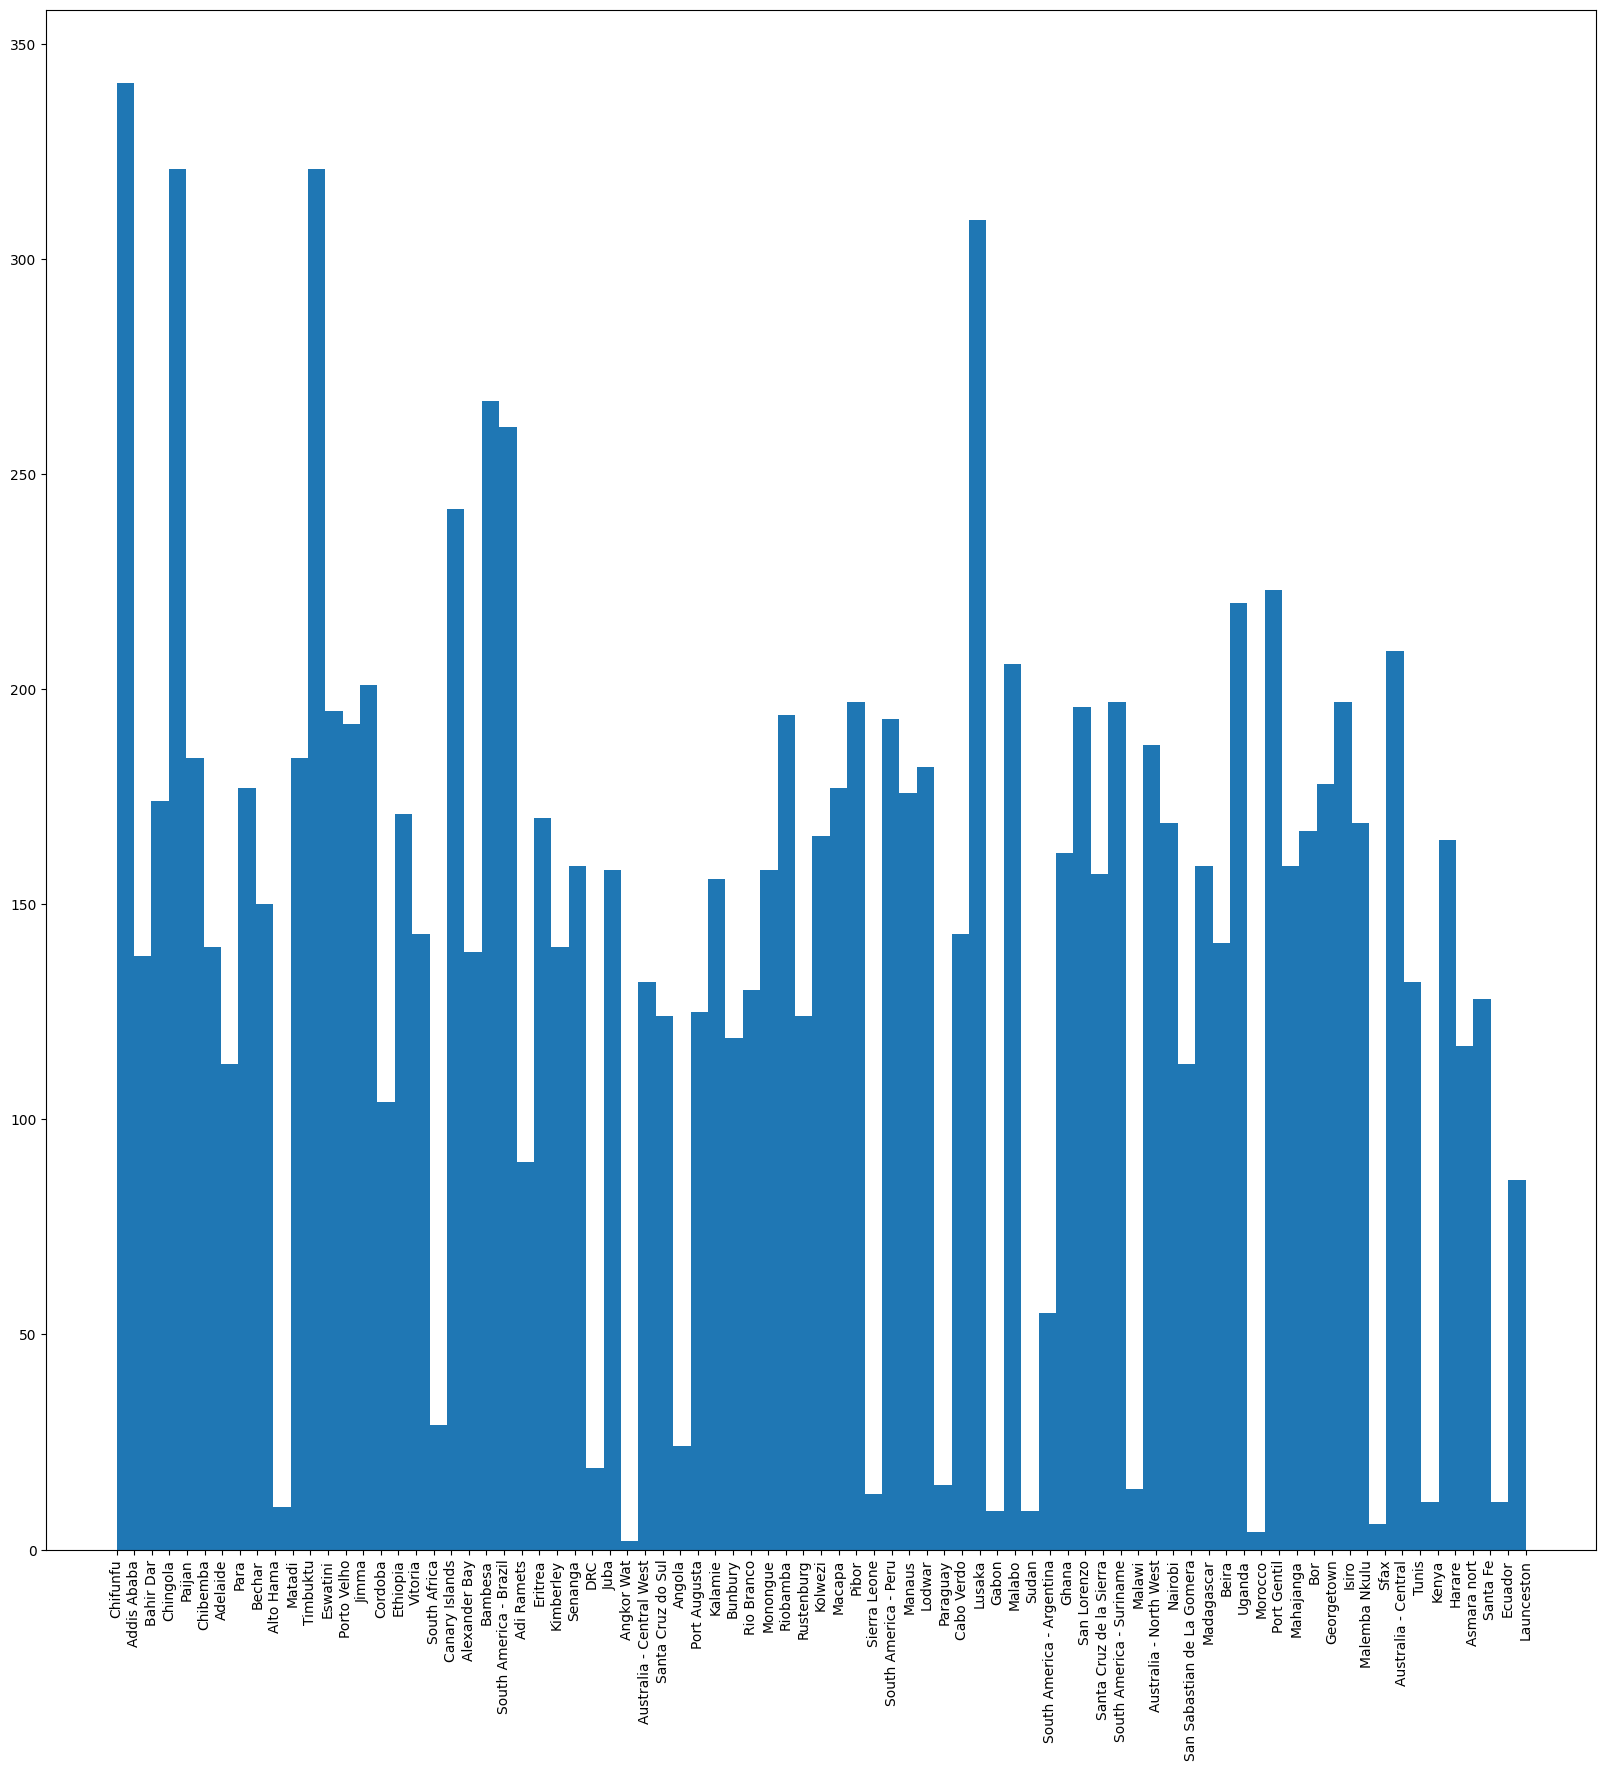

In [8]:
# Plot the distribution of samples across different locations

fig = plt.figure(1, figsize=(20, 20))

ax = fig.add_subplot(111)
plt.hist(metadata.location, bins = 81)
plt.xticks(rotation = 90)

plt.show()

In [34]:
# Extract training and testing data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

# Training data
train_idxs = np.where((metadata.location == 'South America - Brazil'))[0]      #Change for different location
train_features = torch.zeros(train_idxs.shape[0], 4, 512, 512).to(device)
train_labels = torch.zeros(train_idxs.shape[0], 1, 512, 512).to(device)

#Testing data
test_idxs = np.where((metadata.location == 'Kenya'))[0]    #Change for different location
test_features = torch.zeros(test_idxs.shape[0], 4, 512, 512).to(device)
test_labels = torch.zeros(test_idxs.shape[0], 1, 512, 512).to(device)

print('Training data')
for i in range(train_idxs.shape[0]):
    b02_filepath = 'cloud_cover_dataset/data/train_features/' + metadata['chip_id'].iloc[train_idxs[i]] + '/B02.tif'
    print('Reading B02 from file: ', b02_filepath)
    with rio.open(b02_filepath) as b02:
        b02_band = b02.read(1)
        max_b02, min_b02 = np.max(b02_band), np.min(b02_band)
        train_features[i, 0, :, :] = torch.tensor(b02_band/10000/np.pi)    # Conversion to reflectance in sr-1
        b02.close()

    b03_filepath = 'cloud_cover_dataset/data/train_features/' + metadata['chip_id'].iloc[train_idxs[i]] + '/B03.tif'
    print('Reading B03 from file: ', b03_filepath)
    with rio.open(b03_filepath) as b03:
        b03_band = b03.read(1)
        max_b03, min_b03 = np.max(b03_band), np.min(b03_band)
        train_features[i, 1, :, :] = torch.tensor(b03_band/10000/np.pi)    # Conversion to reflectance in sr-1
        b03.close()

    b04_filepath = 'cloud_cover_dataset/data/train_features/' + metadata['chip_id'].iloc[train_idxs[i]] + '/B04.tif'
    print('Reading B04 from file: ', b04_filepath)
    with rio.open(b04_filepath) as b04:
        b04_band = b04.read(1)
        max_b04, min_b04 = np.max(b04_band), np.min(b04_band)
        train_features[i, 2, :, :] = torch.tensor(b04_band/10000/np.pi)    # Conversion to reflectance in sr-1
        b04.close()

    b08_filepath = 'cloud_cover_dataset/data/train_features/' + metadata['chip_id'].iloc[train_idxs[i]] + '/B08.tif'
    print('Reading B08 from file: ', b08_filepath)
    with rio.open(b08_filepath) as b08:
        b08_band = b08.read(1)
        max_b08, min_b08 = np.max(b08_band), np.min(b08_band)
        train_features[i, 3, :, :] = torch.tensor(b08_band/10000/np.pi)    # Conversion to reflectance in sr-1
        b08.close()

    labels_filepath = 'cloud_cover_dataset/data/train_labels/' + metadata['chip_id'].iloc[train_idxs[i]] + '.tif'
    print('Reading Labels from file: ', labels_filepath)
    with rio.open(labels_filepath) as labels:
        train_labels[i, 0, :, :] = torch.tensor(labels.read(1))    #  Extracting labels
        labels.close()

    print('\n')

print('Testing data')
for i in range(test_idxs.shape[0]):
    b02_filepath = 'cloud_cover_dataset/data/train_features/' + metadata['chip_id'].iloc[test_idxs[i]] + '/B02.tif'
    print('Reading B02 from file: ', b02_filepath)
    with rio.open(b02_filepath) as b02:
        b02_band = b02.read(1)
        max_b02, min_b02 = np.max(b02_band), np.min(b02_band)
        test_features[i, 0, :, :] = torch.tensor(b02_band/10000/np.pi)    # Conversion to reflectance in sr-1
        b02.close()

    b03_filepath = 'cloud_cover_dataset/data/train_features/' + metadata['chip_id'].iloc[test_idxs[i]] + '/B03.tif'
    print('Reading B03 from file: ', b03_filepath)
    with rio.open(b03_filepath) as b03:
        b03_band = b03.read(1)
        max_b03, min_b03 = np.max(b03_band), np.min(b03_band)
        test_features[i, 1, :, :] = torch.tensor(b03_band/10000/np.pi)   # Conversion to reflectance in sr-1
        b03.close()

    b04_filepath = 'cloud_cover_dataset/data/train_features/' + metadata['chip_id'].iloc[test_idxs[i]] + '/B04.tif'
    print('Reading B04 from file: ', b04_filepath)
    with rio.open(b04_filepath) as b04:
        b04_band = b04.read(1)
        max_b04, min_b04 = np.max(b04_band), np.min(b04_band)
        test_features[i, 2, :, :] = torch.tensor(b04_band/10000/np.pi)    # Conversion to reflectance in sr-1
        b04.close()

    b08_filepath = 'cloud_cover_dataset/data/train_features/' + metadata['chip_id'].iloc[test_idxs[i]] + '/B08.tif'
    print('Reading B08 from file: ', b08_filepath)
    with rio.open(b08_filepath) as b08:
        b08_band = b08.read(1)
        max_b08, min_b08 = np.max(b08_band), np.min(b08_band)
        test_features[i, 3, :, :] = torch.tensor(b08_band/10000/np.pi)    # Conversion to reflectance in sr-1
        b08.close()

    labels_filepath = 'cloud_cover_dataset/data/train_labels/' + metadata['chip_id'].iloc[test_idxs[i]] + '.tif'
    print('Reading Labels from file: ', labels_filepath)
    with rio.open(labels_filepath) as labels:
        test_labels[i, 0, :, :] = torch.tensor(labels.read(1))    # Extracting labels
        labels.close()

    print('\n')

Using device:  cpu 
Training data
Reading B02 from file:  cloud_cover_dataset/data/train_features/hnau/B02.tif
Reading B03 from file:  cloud_cover_dataset/data/train_features/hnau/B03.tif
Reading B04 from file:  cloud_cover_dataset/data/train_features/hnau/B04.tif
Reading B08 from file:  cloud_cover_dataset/data/train_features/hnau/B08.tif
Reading Labels from file:  cloud_cover_dataset/data/train_labels/hnau.tif


Reading B02 from file:  cloud_cover_dataset/data/train_features/hnca/B02.tif
Reading B03 from file:  cloud_cover_dataset/data/train_features/hnca/B03.tif
Reading B04 from file:  cloud_cover_dataset/data/train_features/hnca/B04.tif
Reading B08 from file:  cloud_cover_dataset/data/train_features/hnca/B08.tif
Reading Labels from file:  cloud_cover_dataset/data/train_labels/hnca.tif


Reading B02 from file:  cloud_cover_dataset/data/train_features/hnce/B02.tif
Reading B03 from file:  cloud_cover_dataset/data/train_features/hnce/B03.tif
Reading B04 from file:  cloud_cover_dataset/

In [162]:
patch_size = 16    # Patch size for image pre-processing
out_labels = 2
train_patches_features = torch.zeros(train_features.shape[0]*((512//patch_size)**2), 4, patch_size, patch_size)
train_patches_labels = torch.zeros(train_features.shape[0]*((512//patch_size)**2), 1, patch_size, patch_size)
train_onehot_labels = torch.zeros(train_features.shape[0]*((512//patch_size)**2), out_labels)


# Split to patches
k=0
for n in range(train_features.shape[0]):
    for i in range(0, 512, patch_size):
        for j in range(0, 512, patch_size):
            train_patches_features[k, :, :, :] = train_features[n, :, i:i+patch_size, j:j+patch_size]    #Image patches
            train_patches_labels[k, :, :, :] = train_labels[n, :, i:i+patch_size, j:j+patch_size]    #Label patches
            
            #Majority label of the patch
            majority_label = 1 if np.count_nonzero(train_labels[n, :, i:i+patch_size, j:j+patch_size].detach().cpu() == 1) >= np.count_nonzero(train_labels[n, :, i:i+patch_size, j:j+patch_size].detach().cpu() == 0) else 0
            # majority_label = int(np.count_nonzero(train_labels[n, :, i:i+patch_size, j:j+patch_size].detach().cpu() == 1) >= np.count_nonzero(train_labels[n, :, i:i+patch_size, j:j+patch_size].detach().cpu() == 0))
            train_onehot_labels[k, majority_label] = 1    #One-hot label
            # train_onehot_labels[k] = majority_label
            k += 1

# print(train_patches_features.shape)
# print(train_patches_features)

In [163]:
test_patches_features = torch.zeros(test_features.shape[0]*((512//patch_size)**2), 4, patch_size, patch_size)
test_patches_labels = torch.zeros(test_features.shape[0]*((512//patch_size)**2), 1, patch_size, patch_size)
test_onehot_labels = torch.zeros(test_features.shape[0]*((512//patch_size)**2), out_labels)

# Split to patches
k=0
for n in range(test_features.shape[0]):
    for i in range(0, 512, patch_size):
        for j in range(0, 512, patch_size):
            test_patches_features[k, :, :, :] = test_features[n, :, i:i+patch_size, j:j+patch_size]    #Image patches
            test_patches_labels[k, :, :, :] = test_labels[n, :, i:i+patch_size, j:j+patch_size]    #Label patches
            
            #Majority label of the patch
            majority_label = 1 if np.count_nonzero(test_labels[n, :, i:i+patch_size, j:j+patch_size].detach().cpu() == 1) >= np.count_nonzero(test_labels[n, :, i:i+patch_size, j:j+patch_size].detach().cpu() == 0) else 0
#             majority_label = int(np.count_nonzero(test_labels[n, :, i:i+patch_size, j:j+patch_size].detach().cpu() == 1) >= np.count_nonzero(test_labels[n, :, i:i+patch_size, j:j+patch_size].detach().cpu() == 0))
            test_onehot_labels[k, majority_label] = 1    #One-hot label
#             test_onehot_labels[k] = majority_label    #Binary label
            k += 1

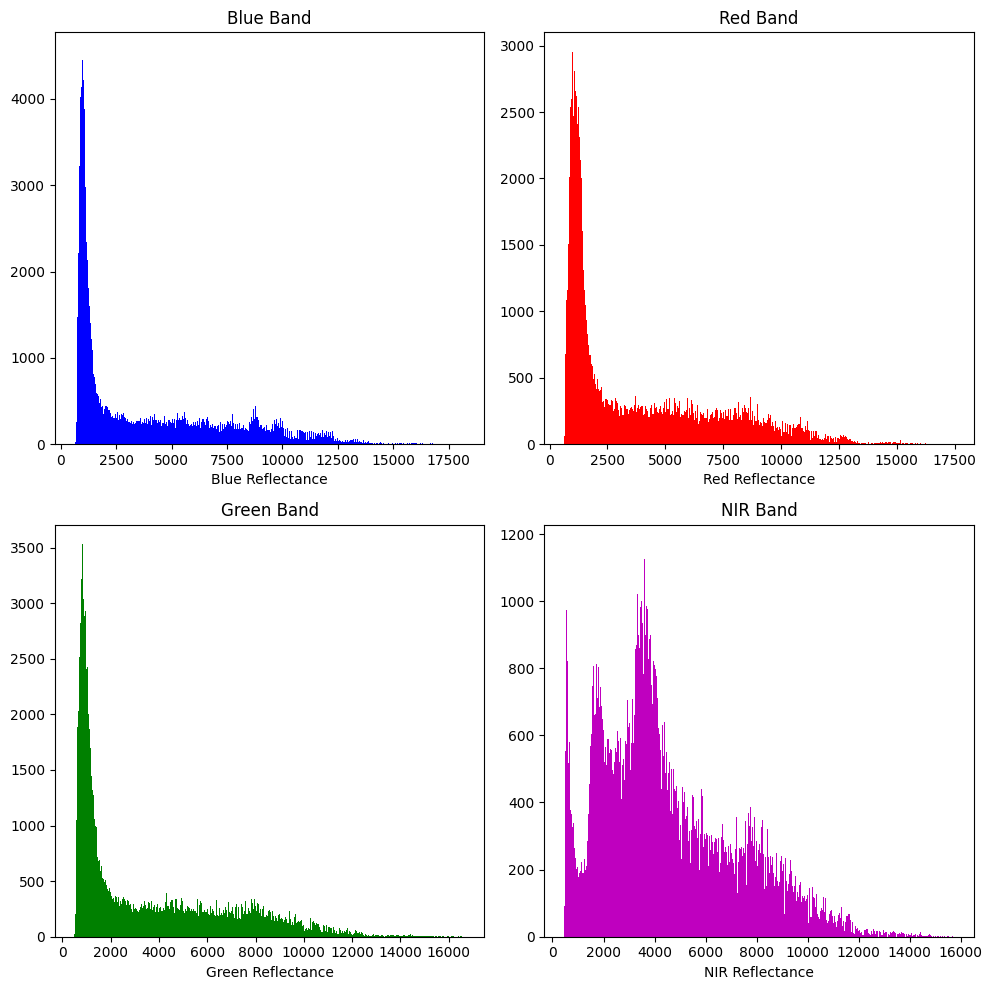

In [137]:
# Visualizing the histogram of reflectances of a random sentinel-2 scene

i = list(random.sample(range(train_features.shape[0]), 1))

blue_features = train_features[i, 0, :, :].flatten().detach().cpu()*10000*np.pi    #Conversion to DN
red_features = train_features[i, 2, :, :].flatten().detach().cpu()*10000*np.pi    #Conversion to DN
green_features = train_features[i, 1, :, :].flatten().detach().cpu()*10000*np.pi    #Conversion to DN
nir_features = train_features[i, 3, :, :].flatten().detach().cpu()*10000*np.pi    #Conversion to DN
labels = train_labels[i, 0, :, :].flatten().detach().cpu()

fig = plt.figure(1, figsize = (10, 10))

ax = fig.add_subplot(221)
plt.hist(blue_features, bins=1000, density = False, color = 'b')
ax.set_xlabel('Blue Reflectance')
ax.set_title('Blue Band')

ax = fig.add_subplot(222)
plt.hist(red_features, bins=1000, density = False, color = 'r')
ax.set_xlabel('Red Reflectance')
ax.set_title('Red Band')

ax = fig.add_subplot(223)
plt.hist(green_features, bins=1000, density = False, color = 'g')
ax.set_xlabel('Green Reflectance')
ax.set_title('Green Band')

ax = fig.add_subplot(224)
plt.hist(nir_features, bins=1000, density = False, color = 'm')
ax.set_xlabel('NIR Reflectance')
ax.set_title('NIR Band')

plt.tight_layout()
plt.show()

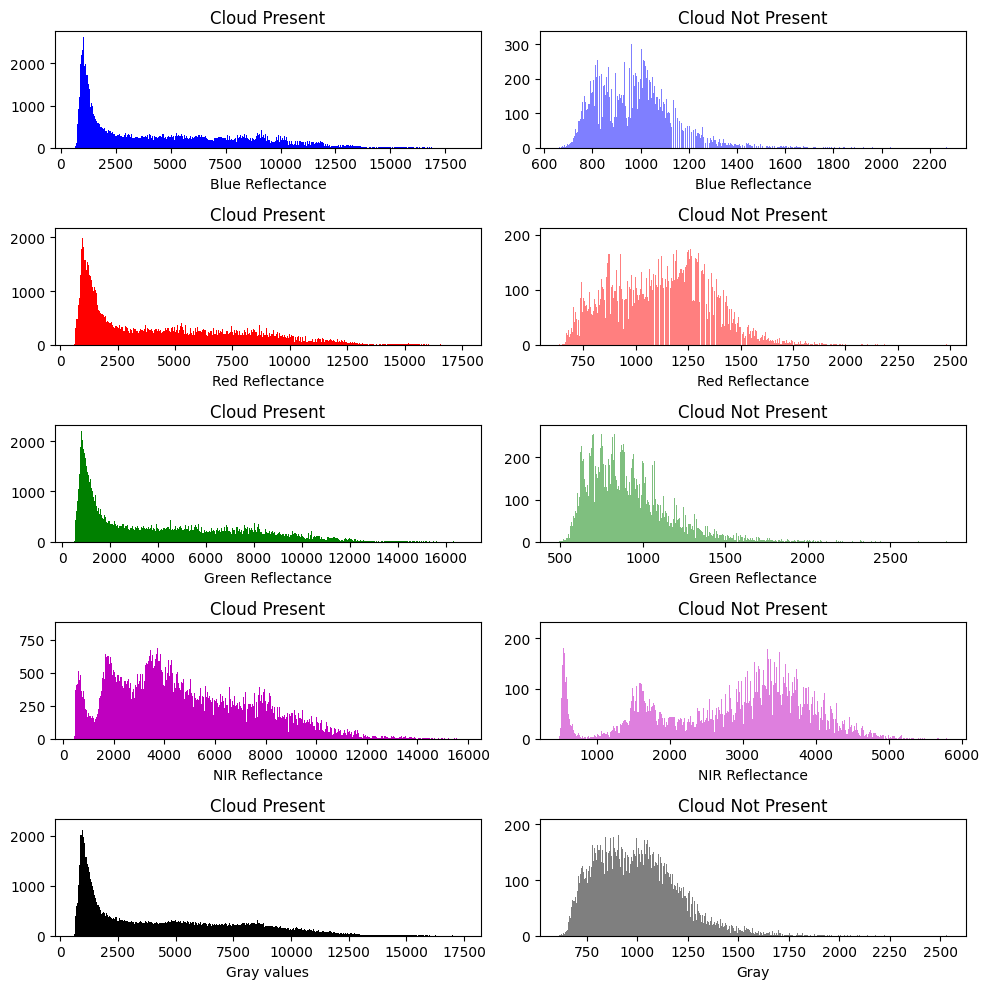

In [138]:
gray_features = (red_features + green_features + blue_features)/3    #Calculating gray values as average of RGB

fig = plt.figure(1, figsize = (10, 10))

ax = fig.add_subplot(5, 2, 1)
plt.hist(blue_features[labels == 1], bins=1000, density = False, color = 'b')    #Histogram of blue reflectances over clouds
ax.set_xlabel('Blue Reflectance')
ax.set_title('Cloud Present')
# ax.set_xlim([0, 0.3])

ax = fig.add_subplot(5, 2, 2)
plt.hist(blue_features[labels == 0], bins=1000, density = False, color = 'b', alpha = 0.5)    #Histogram of blue reflectances over no clouds
ax.set_xlabel('Blue Reflectance')
ax.set_title('Cloud Not Present')
# ax.set_xlim([0, 0.3])

ax = fig.add_subplot(5, 2, 3)
plt.hist(red_features[labels == 1], bins=1000, density = False, color = 'r')    #Histogram of red reflectances over clouds
ax.set_xlabel('Red Reflectance')
ax.set_title('Cloud Present')
# ax.set_xlim([0, 0.3])

ax = fig.add_subplot(5, 2, 4)
plt.hist(red_features[labels == 0], bins=1000, density = False, color = 'r', alpha = 0.5)    #Histogram of red reflectances over no clouds
ax.set_xlabel('Red Reflectance')
ax.set_title('Cloud Not Present')
# ax.set_xlim([0, 0.3])

ax = fig.add_subplot(5, 2, 5)
plt.hist(green_features[labels == 1], bins=1000, density = False, color = 'g')    #Histogram of green reflectances over clouds
ax.set_xlabel('Green Reflectance')
ax.set_title('Cloud Present')
# ax.set_xlim([0, 0.3])

ax = fig.add_subplot(5, 2, 6)
plt.hist(green_features[labels == 0], bins=1000, density = False, color = 'g', alpha = 0.5)    #Histogram of green reflectances over no clouds
ax.set_xlabel('Green Reflectance')
ax.set_title('Cloud Not Present')
# ax.set_xlim([0, 0.3])

ax = fig.add_subplot(5, 2, 7)
plt.hist(nir_features[labels == 1], bins=1000, density = False, color = 'm')    #Histogram of NIR reflectances over clouds
ax.set_xlabel('NIR Reflectance')
ax.set_title('Cloud Present')
# ax.set_xlim([0, 0.3])

ax = fig.add_subplot(5, 2, 8)
plt.hist(nir_features[labels == 0], bins=1000, density = False, color = 'm', alpha = 0.5)    #Histogram of blue reflectances over no clouds
ax.set_xlabel('NIR Reflectance')
ax.set_title('Cloud Not Present')
# ax.set_xlim([0, 0.3])

ax = fig.add_subplot(5, 2, 9)
plt.hist(gray_features[labels == 1], bins=1000, density = False, color = 'k')    #Histogram of gray reflectances over clouds
ax.set_xlabel('Gray values')
ax.set_title('Cloud Present')
# ax.set_xlim([0, 0.3])

ax = fig.add_subplot(5, 2, 10)
plt.hist(gray_features[labels == 0], bins=1000, density = False, color = 'k', alpha = 0.5)    #Histogram of gray reflectances over no clouds
ax.set_xlabel('Gray')
ax.set_title('Cloud Not Present')
# ax.set_xlim([0, 0.3])

plt.tight_layout()
plt.show()

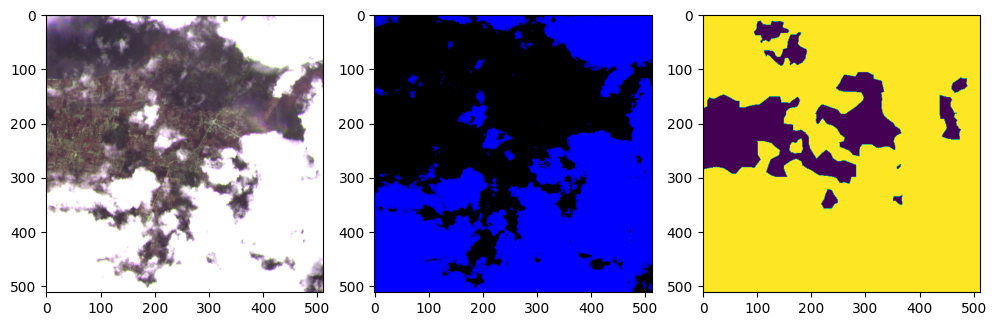

In [139]:
# Visualizing the true color composite, only the blue band, and the labels of the scene

# True color composite
scene = np.zeros((512, 512, 3))
# red_features[:] = 0
# blue_features[blue_features<2000] = 0
# green_features[:] = 0
scene[:, :, 0] = red_features.reshape(512, 512)/10000/np.pi
scene[:, :, 1] = green_features.reshape(512, 512)/10000/np.pi
scene[:, :, 2] = blue_features.reshape(512, 512)/10000/np.pi


fig = plt.figure(1, figsize=(10, 10))

ax = fig.add_subplot(131)
# scene[:, :, 0] = red_features.reshape(512, 512)/10000/np.pi
# scene[:, :, 1] = green_features.reshape(512, 512)/10000/np.pi
# scene[:, :, 2] = blue_features.reshape(512, 512)/10000/np.pi
plt.imshow(scene*10)    #True color composite

ax = fig.add_subplot(132)
#Plotting only the blue reflectances
red_features[:] = 0
blue_features[blue_features<2000] = 0
green_features[:] = 0
scene[:, :, 0] = red_features.reshape(512, 512)/10000/np.pi
scene[:, :, 1] = green_features.reshape(512, 512)/10000/np.pi
scene[:, :, 2] = blue_features.reshape(512, 512)/10000/np.pi
plt.imshow(scene*10)

ax = fig.add_subplot(133)
#Plotting labels
plt.imshow(labels.reshape(512, 512))

plt.tight_layout()
plt.show()

In [17]:
# Main function to train the vision transformer model
# Refered and modified from https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c

import math

def main(batch_size = 32, model = None, N_EPOCHS = 5):
    # Loading data
    transform = ToTensor()

    # train_set = MNIST(root='./../datasets', train=True, download=True, transform=transform)
    # test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform)

    # train_loader = DataLoader((train_features, train_labels), shuffle=True, batch_size=32)
    # test_loader = DataLoader((test_features, test_labels), shuffle=False, batch_size=32)

    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

    if not model:
        model = MyViT().to(device)
    # N_EPOCHS = 5
    LR = 0.005    #Learning rate

    #Splitting data into batches
    num_batches_train = math.ceil(train_patches_features.shape[0]/batch_size)
    train_features_list = [train_patches_features[batch_size*y:batch_size*(y+1),:,:,:] for y in range(num_batches_train)]
#     train_labels_list = [train_patches_labels[batch_size*y:batch_size*(y+1),:,:,:] for y in range(num_batches_train)]
    train_labels_list = [train_onehot_labels[batch_size*y:batch_size*(y+1),:] for y in range(num_batches_train)]

    #Splitting data into batches
    num_batches_test = math.ceil(test_patches_features.shape[0]/batch_size)
    test_features_list = [test_patches_features[batch_size*y:batch_size*(y+1),:,:,:] for y in range(num_batches_test)]
#     test_labels_list = [test_patches_labels[batch_size*y:batch_size*(y+1),:,:,:] for y in range(num_batches_test)]
    test_labels_list = [test_onehot_labels[batch_size*y:batch_size*(y+1),:] for y in range(num_batches_test)]

    train_loss_history = []    #Training loss over each epoch
    test_loss_history = []    #Testing loss over each epoch

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)    #Adam optimizer
    criterion = nn.BCELoss()    #Binary Cross-Entropy Loss
    # criterion = nn.MSELoss()
    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0; test_loss = 0.0
        for i in range(len(train_features_list)):
            x, y = train_features_list[i], train_labels_list[i]    #batch
            x, y = x.to(device), y.to(device)    #transfer to computing hardware (cpu/gpu)
            y_hat = model(x)    #model output
            loss = criterion(y_hat, y)    #Loss

            train_loss += loss.detach().cpu().item() / len(train_features_list)    #Training loss

            optimizer.zero_grad()    
            loss.backward()    #Gradient of loss
            optimizer.step()    #Weight update
        train_loss_history.append(train_loss)    #Epoch update of training loss

        for i in range(len(test_features_list)):
            x, y = test_features_list[i], test_labels_list[i]    #test batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_features_list)    #test loss

        test_loss_history.append(test_loss)    #Epoch update of testing loss

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.6f}")

    # Test loop for accuracy calculation
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for i in range(len(test_features_list)):
            x, y = test_features_list[i], test_labels_list[i]
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_features_list)
            correct += torch.sum(torch.argmax(y_hat, dim=1) == torch.argmax(y, dim=1)).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.6f}")
        print(f"Test accuracy: {correct / total * 100:.6f}%")

    return train_loss_history, test_loss_history

In [11]:
# Create patches for the transformer model from the input image patch

def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

In [12]:
# Calculate positional embeddings

def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [13]:
# Multihead Self-Attention Module

class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))    #Scalar dot-product attention score
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])    #Concatenation

In [14]:
# Transformer encoder block

class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

In [165]:
#Transformer module

class MyViT(nn.Module):
    def __init__(self, chw = (4, patch_size, patch_size), n_patches=4, n_blocks=2, hidden_d=8, n_heads=2, out_d=2):
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw # ( C, H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])

        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0]
        return self.mlp(out) # Map to output dimension, output category distribution

In [166]:
model = MyViT()
x = torch.randn(10, 4, patch_size, patch_size)
y = model(x)
y.shape

torch.Size([10, 2])

In [167]:
model = MyViT().to(device)

train_loss, test_loss = main(batch_size = 32, model = model, N_EPOCHS=5)

Using device:  cpu 


Training:  20%|██        | 1/5 [12:44<50:59, 764.81s/it]

Epoch 1/5 loss: 0.073201


Training:  40%|████      | 2/5 [25:28<38:12, 764.05s/it]

Epoch 2/5 loss: 0.042944


Training:  60%|██████    | 3/5 [38:13<25:28, 764.33s/it]

Epoch 3/5 loss: 0.037386


Training:  80%|████████  | 4/5 [50:50<12:41, 761.72s/it]

Epoch 4/5 loss: 0.042975


Training: 100%|██████████| 5/5 [1:03:42<00:00, 764.45s/it]

Epoch 5/5 loss: 0.043471


Test loss: 3.440070
Test accuracy: 1.367188%


In [206]:
predicted_patches = model(test_patches_features)    #Calculate model output

In [207]:
predicted_labels = torch.zeros(test_features.shape[0], 1, 512, 512)    #Stitch model output

k=0
for n in range(test_features.shape[0]):
    for i in range(0, 512, patch_size):
        for j in range(0, 512, patch_size):
#             predicted_labels[n, :, i:i+32, j:j+32] = predicted_patches[k, :, :, :]
            predicted_labels[n, :, i:i+patch_size, j:j+patch_size] = torch.argmax(predicted_patches[k])
            k+=1

In [208]:
# Receiver operating Characteristics point calculation using TPR and FPR

TP = 0; FP = 0; TN = 0; FN = 0

for n in range(test_labels.shape[0]):
    for i in range(512):
        for j in range(512):
            if (int(predicted_labels[n, 0, i, j].detach().cpu()) == 1) and (int(test_labels[n, 0, i, j].detach().cpu()) == 1):
                TP += 1
            elif (int(predicted_labels[n, 0, i, j].detach().cpu()) == 1) and (int(test_labels[n, 0, i, j].detach().cpu()) == 0):
                FP += 1
            elif (int(predicted_labels[n, 0, i, j].detach().cpu()) == 0) and (int(test_labels[n, 0, i, j].detach().cpu()) == 0):
                TN += 1
            else:
                FN += 1

In [209]:
# Calculating TPR and FPR

TPR = TP/(TP + FN); FPR = FP/(TN + FP); F1 = 2*TP/((2*TP) + FP + FN)

In [210]:
print(f'TPR: {TPR}')
print(f'FPR: {FPR}')
print(f'F1: {F1}')

TPR: 0.9999337080407411
FPR: 0.9784674190722616
F1: 0.5414560414554005


[10]


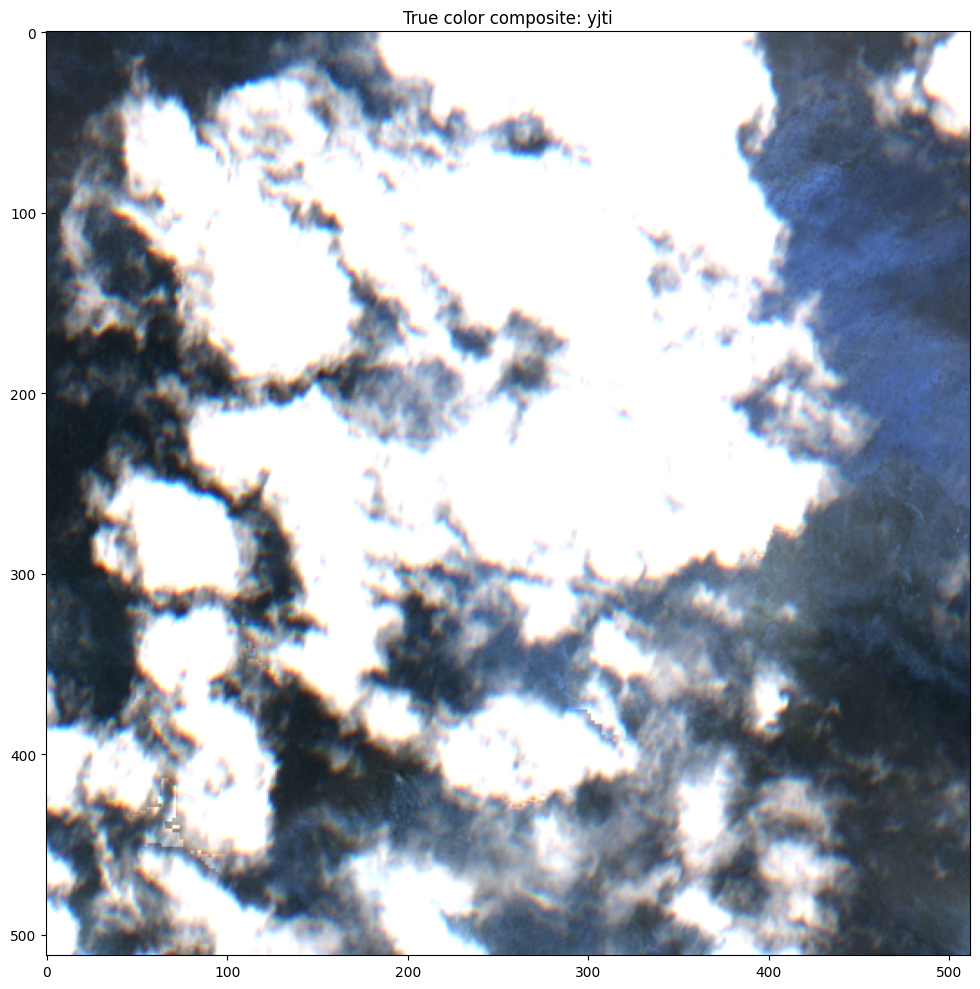

In [224]:
# Display random scene as true color composite

i = np.random.randint(predicted_labels.shape[0], size=1)
print(i)
fig = plt.figure(1, figsize=(10, 10))
scene = np.zeros((512, 512, 3))

ax = fig.add_subplot(111)
scene[:, :, 0] = test_features[i, 2].reshape(512, 512).detach().cpu()
scene[:, :, 1] = test_features[i, 1].reshape(512, 512).detach().cpu()
scene[:, :, 2] = test_features[i, 0].reshape(512, 512).detach().cpu()
plt.imshow(scene*10)
ax.set_title('True color composite: '+metadata['chip_id'].iloc[test_idxs[i][0]])

plt.tight_layout()
plt.show()

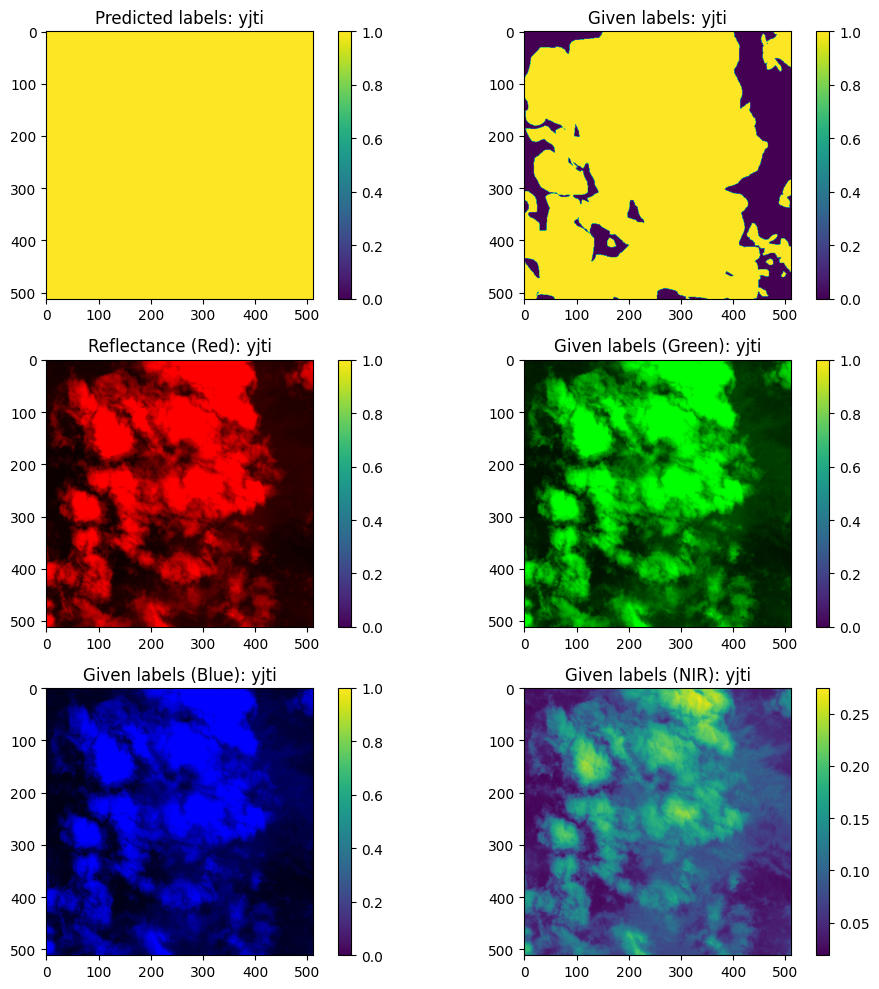

In [225]:
# Display the predicted labels, given labels, and reflectance across all the bands

fig = plt.figure(1, figsize=(10, 10))


ax = fig.add_subplot(321)
plt.imshow(predicted_labels[i].reshape(512, 512).detach().cpu())    #Predicted labels
ax.set_title('Predicted labels: '+metadata['chip_id'].iloc[test_idxs[i][0]])
plt.colorbar()
plt.clim([0, 1])

ax = fig.add_subplot(322)
plt.imshow(test_labels[i].reshape(512, 512).detach().cpu())     #Given labels
ax.set_title('Given labels: '+metadata['chip_id'].iloc[test_idxs[i][0]])
plt.colorbar()
plt.clim([0, 1])

ax = fig.add_subplot(323)
scene[:, :, [1, 2]] = 0
scene[:, :, 0] = test_features[i, 2].reshape(512, 512).detach().cpu()
plt.imshow(scene*6)    #Red reflectance
ax.set_title('Reflectance (Red): '+metadata['chip_id'].iloc[test_idxs[i][0]])
plt.colorbar(cmap='Reds')

ax = fig.add_subplot(324)
scene[:, :, [0, 2]] = 0
scene[:, :, 1] = test_features[i, 1].reshape(512, 512).detach().cpu()
plt.imshow(scene*6)    #Green Reflectance
ax.set_title('Given labels (Green): '+metadata['chip_id'].iloc[test_idxs[i][0]])
plt.colorbar(cmap='Greens')

ax = fig.add_subplot(325)
scene[:, :, [0, 1]] = 0
scene[:, :, 2] = test_features[i, 0].reshape(512, 512).detach().cpu()
plt.imshow(scene*6)    #Blue Reflectance
ax.set_title('Given labels (Blue): '+metadata['chip_id'].iloc[test_idxs[i][0]])
plt.colorbar(cmap='Blues')

ax = fig.add_subplot(326)
plt.imshow(test_features[i, 3].reshape(512, 512).detach().cpu())    #NIR Reflectance
ax.set_title('Given labels (NIR): '+metadata['chip_id'].iloc[test_idxs[i][0]])
plt.colorbar()

plt.tight_layout()
plt.show()